In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import random_split

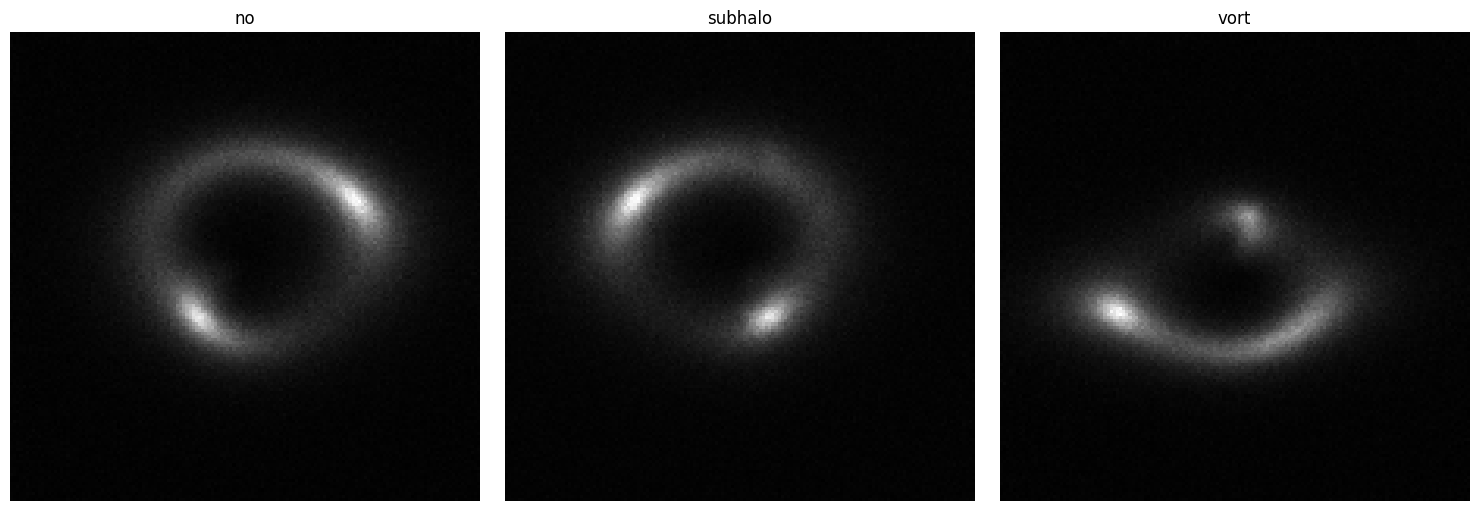

In [2]:
no = np.load("/home/hamee/flow/classification_data/train/no/1.npy")
subhalo = np.load("/home/hamee/flow/classification_data/train/sphere/1.npy")
vortex = np.load("/home/hamee/flow/classification_data/train/vort/1.npy")

def plot_samples_horizontally(samples_dict):
    plt.figure(figsize=(15, 5))
    
    for i, (label, img) in enumerate(samples_dict.items()):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img[0], cmap="gray")
        plt.title(label)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

samples = {
    "no": no,
    "subhalo": subhalo,
    "vort": vortex
}

plot_samples_horizontally(samples)

In [3]:
torch.manual_seed(42)
np.random.seed(42)

NUM_CLASSES = 3
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class GravitationalLensingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for file_path in glob.glob(os.path.join(class_dir, "*.npy")):
                    self.samples.append((file_path, self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        image = np.load(file_path)
        image = torch.from_numpy(image).float()
        
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
        
        if self.transform:
            image = self.transform(image)
                    
        return image, label

In [27]:
transform = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(0.5),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
}

In [28]:
def load_data(data_dir):
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    
    train_dir_dataset = GravitationalLensingDataset(train_dir, transform=transform['train'])
    test_dataset = GravitationalLensingDataset(val_dir, transform=transform['val'])

    num_images = len(train_dir_dataset)

    # number of images for training (90%) and testing (10%)
    train_size = int(num_images * 0.9)
    val_size = num_images - train_size

    # Split the dataset
    train_dataset, val_dataset = random_split(train_dir_dataset, [train_size, val_size])
    print(len(train_dataset), len(val_dataset), len(test_dataset))
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    return train_loader, val_loader, test_loader, train_dir_dataset.class_to_idx

In [29]:
def initialize_model():
    model = models.resnet34(weights='IMAGENET1K_V1')
    
    # Replace the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    
    return model

In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name):
    model.to(DEVICE)
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Add tqdm progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({'loss': loss.item(), 'acc': correct/total})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        # Add tqdm progress bar for validation
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                val_pbar.set_postfix({'loss': loss.item(), 'acc': val_correct/val_total})
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
        
        # Save best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), f'best_{model_name}_classification_model.pt')
            print(f'New best model saved with validation accuracy: {best_val_acc:.4f}')
    
    return model, history

In [31]:
data_dir = '/home/hamee/flow/classification_data'  
    
train_loader, val_loader, test_loader, class_to_idx = load_data(data_dir)

model = initialize_model()
model = torch.compile(model, mode="reduce-overhead")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

27000 3000 7500


## Training Resnet34

In [10]:
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, model_name="resnet34")

Epoch 1/50 [Val]: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s, loss=4.07, acc=0.353]


Epoch 1/50: Train Loss: 1.0942, Train Acc: 0.3721, Val Loss: 3.8967, Val Acc: 0.3533
New best model saved with validation accuracy: 0.3533


Epoch 2/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.58it/s, loss=0.811, acc=0.716]


Epoch 2/50: Train Loss: 0.5489, Train Acc: 0.7645, Val Loss: 0.8975, Val Acc: 0.7157
New best model saved with validation accuracy: 0.7157


Epoch 3/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.42it/s, loss=0.34, acc=0.854] 


Epoch 3/50: Train Loss: 0.3611, Train Acc: 0.8626, Val Loss: 0.4173, Val Acc: 0.8537
New best model saved with validation accuracy: 0.8537


Epoch 4/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.21it/s, loss=0.397, acc=0.875]


Epoch 4/50: Train Loss: 0.2958, Train Acc: 0.8889, Val Loss: 0.3506, Val Acc: 0.8753
New best model saved with validation accuracy: 0.8753


Epoch 5/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.45it/s, loss=0.274, acc=0.898]


Epoch 5/50: Train Loss: 0.2640, Train Acc: 0.9027, Val Loss: 0.2661, Val Acc: 0.8977
New best model saved with validation accuracy: 0.8977


Epoch 6/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.30it/s, loss=0.451, acc=0.89] 


Epoch 6/50: Train Loss: 0.2353, Train Acc: 0.9139, Val Loss: 0.3610, Val Acc: 0.8900


Epoch 7/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.26it/s, loss=0.763, acc=0.767]


Epoch 7/50: Train Loss: 0.2208, Train Acc: 0.9190, Val Loss: 0.7616, Val Acc: 0.7673


Epoch 8/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.33it/s, loss=0.608, acc=0.817]


Epoch 8/50: Train Loss: 0.2007, Train Acc: 0.9268, Val Loss: 0.4738, Val Acc: 0.8170


Epoch 9/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.26it/s, loss=0.451, acc=0.752]


Epoch 9/50: Train Loss: 0.1866, Train Acc: 0.9333, Val Loss: 0.7403, Val Acc: 0.7523


Epoch 10/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.02it/s, loss=0.821, acc=0.788]


Epoch 10/50: Train Loss: 0.1733, Train Acc: 0.9388, Val Loss: 0.5833, Val Acc: 0.7883


Epoch 11/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.36it/s, loss=0.191, acc=0.928]


Epoch 11/50: Train Loss: 0.1788, Train Acc: 0.9376, Val Loss: 0.1961, Val Acc: 0.9280
New best model saved with validation accuracy: 0.9280


Epoch 12/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.32it/s, loss=0.243, acc=0.918]


Epoch 12/50: Train Loss: 0.1668, Train Acc: 0.9411, Val Loss: 0.2553, Val Acc: 0.9180


Epoch 13/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.35it/s, loss=0.271, acc=0.933]


Epoch 13/50: Train Loss: 0.1628, Train Acc: 0.9413, Val Loss: 0.1913, Val Acc: 0.9327
New best model saved with validation accuracy: 0.9327


Epoch 14/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.14it/s, loss=1.04, acc=0.759] 


Epoch 14/50: Train Loss: 0.1544, Train Acc: 0.9448, Val Loss: 0.8818, Val Acc: 0.7593


Epoch 15/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.40it/s, loss=0.223, acc=0.912]


Epoch 15/50: Train Loss: 0.1506, Train Acc: 0.9466, Val Loss: 0.2406, Val Acc: 0.9117


Epoch 16/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.37it/s, loss=0.222, acc=0.913]


Epoch 16/50: Train Loss: 0.1446, Train Acc: 0.9488, Val Loss: 0.2326, Val Acc: 0.9133


Epoch 17/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.33it/s, loss=0.172, acc=0.933] 


Epoch 17/50: Train Loss: 0.1358, Train Acc: 0.9523, Val Loss: 0.1830, Val Acc: 0.9333
New best model saved with validation accuracy: 0.9333


Epoch 18/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.39it/s, loss=0.149, acc=0.943] 


Epoch 18/50: Train Loss: 0.1301, Train Acc: 0.9540, Val Loss: 0.1684, Val Acc: 0.9433
New best model saved with validation accuracy: 0.9433


Epoch 19/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.42it/s, loss=0.149, acc=0.937] 


Epoch 19/50: Train Loss: 0.1348, Train Acc: 0.9523, Val Loss: 0.1818, Val Acc: 0.9367


Epoch 20/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.55it/s, loss=0.296, acc=0.933] 


Epoch 20/50: Train Loss: 0.1264, Train Acc: 0.9551, Val Loss: 0.1899, Val Acc: 0.9330


Epoch 21/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  4.94it/s, loss=0.373, acc=0.914]


Epoch 21/50: Train Loss: 0.1278, Train Acc: 0.9546, Val Loss: 0.2355, Val Acc: 0.9143


Epoch 22/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.32it/s, loss=0.73, acc=0.862] 


Epoch 22/50: Train Loss: 0.1211, Train Acc: 0.9573, Val Loss: 0.3900, Val Acc: 0.8620


Epoch 23/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.18it/s, loss=0.277, acc=0.93] 


Epoch 23/50: Train Loss: 0.1097, Train Acc: 0.9622, Val Loss: 0.1877, Val Acc: 0.9303


Epoch 24/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.00it/s, loss=0.303, acc=0.93] 


Epoch 24/50: Train Loss: 0.1126, Train Acc: 0.9600, Val Loss: 0.1930, Val Acc: 0.9300


Epoch 25/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.11it/s, loss=0.248, acc=0.931] 


Epoch 25/50: Train Loss: 0.1112, Train Acc: 0.9618, Val Loss: 0.1968, Val Acc: 0.9310


Epoch 26/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.30it/s, loss=0.31, acc=0.928]  


Epoch 26/50: Train Loss: 0.1105, Train Acc: 0.9609, Val Loss: 0.2022, Val Acc: 0.9280


Epoch 27/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.31it/s, loss=0.106, acc=0.947] 


Epoch 27/50: Train Loss: 0.1070, Train Acc: 0.9625, Val Loss: 0.1552, Val Acc: 0.9470
New best model saved with validation accuracy: 0.9470


Epoch 28/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.60it/s, loss=0.299, acc=0.935] 


Epoch 28/50: Train Loss: 0.1004, Train Acc: 0.9644, Val Loss: 0.2015, Val Acc: 0.9350


Epoch 29/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.07it/s, loss=0.245, acc=0.945] 


Epoch 29/50: Train Loss: 0.0969, Train Acc: 0.9657, Val Loss: 0.1686, Val Acc: 0.9450


Epoch 30/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  4.98it/s, loss=0.202, acc=0.955] 


Epoch 30/50: Train Loss: 0.0933, Train Acc: 0.9665, Val Loss: 0.1433, Val Acc: 0.9550
New best model saved with validation accuracy: 0.9550


Epoch 31/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.33it/s, loss=0.0972, acc=0.943]


Epoch 31/50: Train Loss: 0.0937, Train Acc: 0.9671, Val Loss: 0.2214, Val Acc: 0.9427


Epoch 32/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.22it/s, loss=0.337, acc=0.949] 


Epoch 32/50: Train Loss: 0.0940, Train Acc: 0.9663, Val Loss: 0.1675, Val Acc: 0.9487


Epoch 33/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.18it/s, loss=0.091, acc=0.927]


Epoch 33/50: Train Loss: 0.0889, Train Acc: 0.9680, Val Loss: 0.2974, Val Acc: 0.9270


Epoch 34/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.47it/s, loss=0.102, acc=0.945] 


Epoch 34/50: Train Loss: 0.0865, Train Acc: 0.9690, Val Loss: 0.1676, Val Acc: 0.9450


Epoch 35/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.78it/s, loss=0.257, acc=0.939] 


Epoch 35/50: Train Loss: 0.0817, Train Acc: 0.9708, Val Loss: 0.2097, Val Acc: 0.9387


Epoch 36/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.24it/s, loss=0.166, acc=0.938] 


Epoch 36/50: Train Loss: 0.0812, Train Acc: 0.9716, Val Loss: 0.1797, Val Acc: 0.9383


Epoch 37/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.22it/s, loss=0.215, acc=0.944] 


Epoch 37/50: Train Loss: 0.0820, Train Acc: 0.9705, Val Loss: 0.1679, Val Acc: 0.9443


Epoch 38/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.19it/s, loss=0.207, acc=0.94] 


Epoch 38/50: Train Loss: 0.0771, Train Acc: 0.9730, Val Loss: 0.1898, Val Acc: 0.9400


Epoch 39/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.21it/s, loss=0.187, acc=0.944] 


Epoch 39/50: Train Loss: 0.0795, Train Acc: 0.9719, Val Loss: 0.2043, Val Acc: 0.9440


Epoch 40/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.25it/s, loss=0.237, acc=0.948] 


Epoch 40/50: Train Loss: 0.0702, Train Acc: 0.9760, Val Loss: 0.1538, Val Acc: 0.9477


Epoch 41/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.28it/s, loss=0.107, acc=0.943] 


Epoch 41/50: Train Loss: 0.0733, Train Acc: 0.9745, Val Loss: 0.2104, Val Acc: 0.9430


Epoch 42/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.04it/s, loss=0.232, acc=0.931]


Epoch 42/50: Train Loss: 0.0729, Train Acc: 0.9739, Val Loss: 0.1961, Val Acc: 0.9310


Epoch 43/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.39it/s, loss=0.359, acc=0.947] 


Epoch 43/50: Train Loss: 0.0685, Train Acc: 0.9767, Val Loss: 0.1973, Val Acc: 0.9467


Epoch 44/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.25it/s, loss=0.123, acc=0.938] 


Epoch 44/50: Train Loss: 0.0660, Train Acc: 0.9762, Val Loss: 0.1929, Val Acc: 0.9377


Epoch 45/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.29it/s, loss=0.222, acc=0.958] 


Epoch 45/50: Train Loss: 0.0659, Train Acc: 0.9778, Val Loss: 0.1533, Val Acc: 0.9580
New best model saved with validation accuracy: 0.9580


Epoch 46/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.17it/s, loss=0.153, acc=0.951] 


Epoch 46/50: Train Loss: 0.0631, Train Acc: 0.9785, Val Loss: 0.1462, Val Acc: 0.9513


Epoch 47/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.11it/s, loss=0.272, acc=0.944] 


Epoch 47/50: Train Loss: 0.0630, Train Acc: 0.9775, Val Loss: 0.1448, Val Acc: 0.9437


Epoch 48/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.13it/s, loss=0.185, acc=0.948] 


Epoch 48/50: Train Loss: 0.0606, Train Acc: 0.9785, Val Loss: 0.1602, Val Acc: 0.9477


Epoch 49/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.16it/s, loss=0.167, acc=0.951] 


Epoch 49/50: Train Loss: 0.0610, Train Acc: 0.9778, Val Loss: 0.1460, Val Acc: 0.9510


Epoch 50/50 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.33it/s, loss=0.206, acc=0.94]  

Epoch 50/50: Train Loss: 0.0623, Train Acc: 0.9769, Val Loss: 0.1571, Val Acc: 0.9403


In [32]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    all_probs = [] 
    
    test_pbar = tqdm(test_loader, desc='Evaluating on test set')
    with torch.no_grad():
        for inputs, labels in test_pbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            probs = torch.nn.functional.softmax(outputs, dim=1)  
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  
            
            test_pbar.set_postfix({'loss': loss.item(), 'acc': test_correct/test_total})
    
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    
    cm = confusion_matrix(all_labels, all_preds)
    
    all_labels_np = np.array(all_labels)
    all_probs_np = np.array(all_probs)
    
    n_classes = all_probs_np.shape[1]
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(n_classes):
        binary_labels = (all_labels_np == i).astype(int)
        class_probs = all_probs_np[:, i]
        
        fpr[i], tpr[i], _ = roc_curve(binary_labels, class_probs)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    macro_roc_auc = sum(roc_auc.values()) / n_classes
    print(f'Macro-averaged ROC AUC: {macro_roc_auc:.4f}')
    
    return test_loss, test_acc, cm, all_labels, all_preds, all_probs_np, fpr, tpr, roc_auc, macro_roc_auc


def plot_roc_curves(fpr, tpr, roc_auc, save_path=None):
    plt.figure(figsize=(10, 8))
    
    for i in fpr.keys():
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve for class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


def plot_history(history, num_epochs=NUM_EPOCHS):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. Epoch')
    plt.xlim(0, num_epochs - 1)  # Set x-axis range
    plt.ylim(0, 1)  # Loss should ideally be positive, but limiting to 0-1 depends on the problem
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs. Epoch')
    plt.xlim(0, num_epochs - 1)  # Set x-axis range
    plt.ylim(0, 1)  # Accuracy is always between 0 and 1
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()


def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix_2.png')
    plt.show()

In [ ]:
test_loss, test_acc, cm, all_labels, all_preds, all_probs, fpr, tpr, roc_auc, macro_roc_auc = evaluate_model(model, test_loader, criterion)

Evaluating on test set: 100%|██████████| 59/59 [00:07<00:00,  8.03it/s, loss=0.0637, acc=0.964] 

Test Loss: 0.1131, Test Accuracy: 0.9639
Macro-averaged ROC AUC: 0.9948


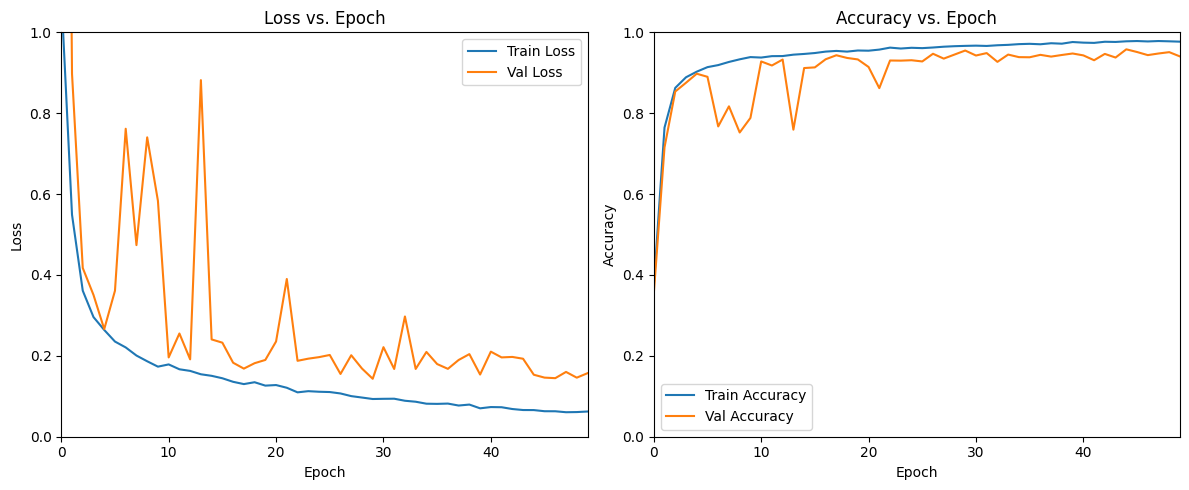

In [24]:
plot_history(history)

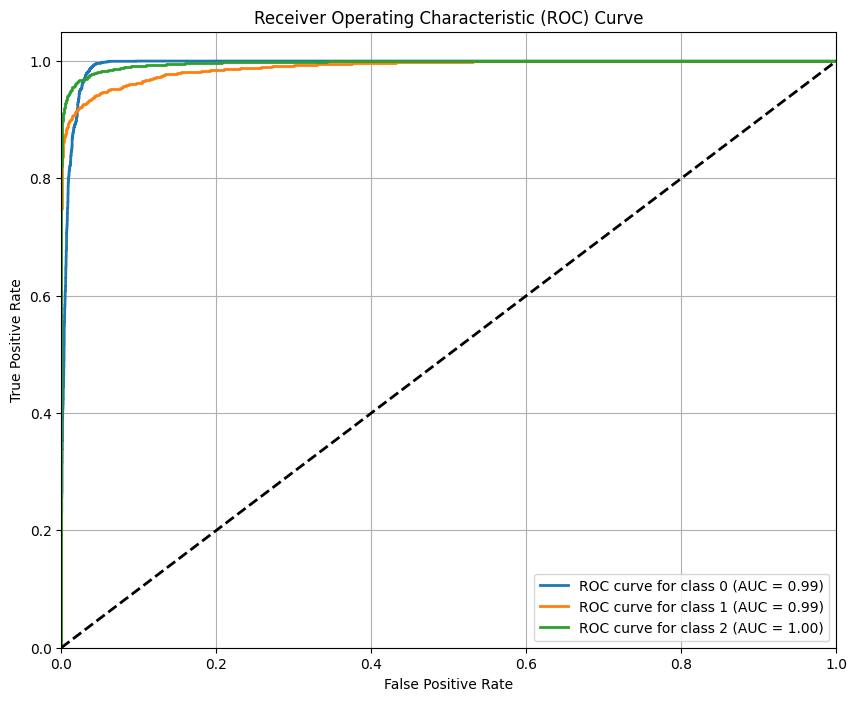

In [19]:
plot_roc_curves(fpr, tpr, roc_auc)

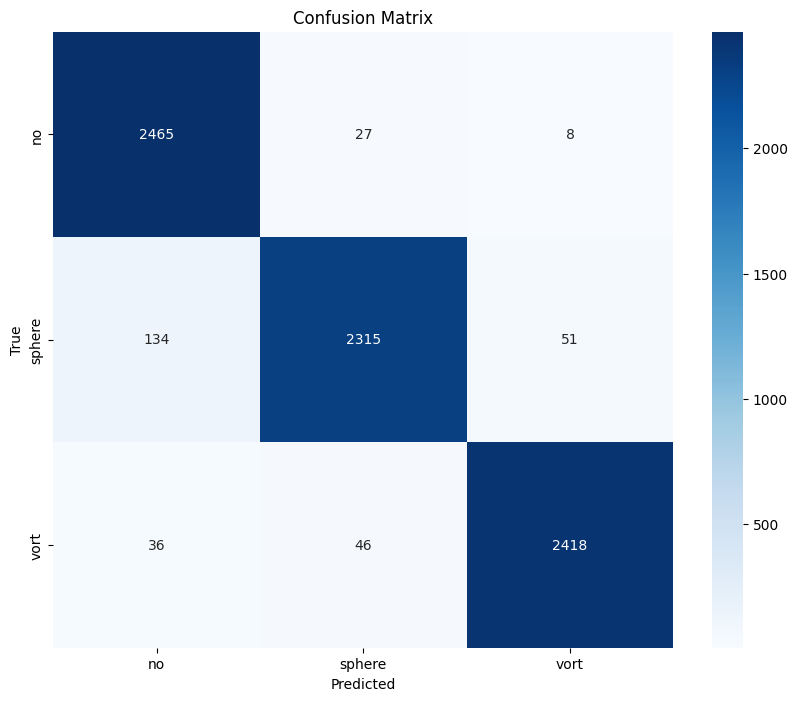

In [25]:
class_names = [k for k, v in sorted(class_to_idx.items(), key=lambda x: x[1])]
plot_confusion_matrix(cm, class_names)

## Training EfficientNet B3

In [10]:
def initialize_efficientnet_model():
    model = models.efficientnet_b3(weights='IMAGENET1K_V1')
    
    # Replace the final fully connected layer
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
    
    return model

In [ ]:
model_efnet = initialize_efficientnet_model()
model_efnet = torch.compile(model_efnet, mode="reduce-overhead")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efnet.parameters(), lr=LEARNING_RATE)

In [14]:
model_efnet, history_efnet = train_model(model_efnet, train_loader, val_loader, criterion, optimizer, 20, model_name="efnet_b3")

Epoch 1/20 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 1/20 [Val]: 100%|██████████| 24/24 [00:08<00:00,  2.85it/s, loss=0.156, acc=0.923]


Epoch 1/20: Train Loss: 0.2270, Train Acc: 0.9178, Val Loss: 0.2406, Val Acc: 0.9227
New best model saved with validation accuracy: 0.9227


Epoch 2/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.28it/s, loss=0.188, acc=0.921]


Epoch 2/20: Train Loss: 0.1953, Train Acc: 0.9301, Val Loss: 0.2191, Val Acc: 0.9207


Epoch 3/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.23it/s, loss=0.155, acc=0.925]


Epoch 3/20: Train Loss: 0.1860, Train Acc: 0.9343, Val Loss: 0.2189, Val Acc: 0.9253
New best model saved with validation accuracy: 0.9253


Epoch 4/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.14it/s, loss=0.188, acc=0.928]


Epoch 4/20: Train Loss: 0.1672, Train Acc: 0.9413, Val Loss: 0.2360, Val Acc: 0.9283
New best model saved with validation accuracy: 0.9283


Epoch 5/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.11it/s, loss=0.497, acc=0.841]


Epoch 5/20: Train Loss: 0.1613, Train Acc: 0.9431, Val Loss: 0.4389, Val Acc: 0.8413


Epoch 6/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.11it/s, loss=0.17, acc=0.946]  


Epoch 6/20: Train Loss: 0.1555, Train Acc: 0.9448, Val Loss: 0.1694, Val Acc: 0.9457
New best model saved with validation accuracy: 0.9457


Epoch 7/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.21it/s, loss=0.121, acc=0.942]


Epoch 7/20: Train Loss: 0.1459, Train Acc: 0.9485, Val Loss: 0.1605, Val Acc: 0.9423


Epoch 8/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.20it/s, loss=0.136, acc=0.944] 


Epoch 8/20: Train Loss: 0.1369, Train Acc: 0.9517, Val Loss: 0.1676, Val Acc: 0.9437


Epoch 9/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.19it/s, loss=0.0993, acc=0.954]


Epoch 9/20: Train Loss: 0.1320, Train Acc: 0.9532, Val Loss: 0.1414, Val Acc: 0.9540
New best model saved with validation accuracy: 0.9540


Epoch 10/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.14it/s, loss=0.0705, acc=0.95] 


Epoch 10/20: Train Loss: 0.1239, Train Acc: 0.9561, Val Loss: 0.1534, Val Acc: 0.9503


Epoch 11/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.21it/s, loss=0.176, acc=0.944] 


Epoch 11/20: Train Loss: 0.1251, Train Acc: 0.9566, Val Loss: 0.1826, Val Acc: 0.9440


Epoch 12/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.05it/s, loss=0.214, acc=0.93] 


Epoch 12/20: Train Loss: 0.1126, Train Acc: 0.9599, Val Loss: 0.2675, Val Acc: 0.9297


Epoch 13/20 [Val]: 100%|██████████| 24/24 [00:08<00:00,  2.92it/s, loss=0.185, acc=0.926]


Epoch 13/20: Train Loss: 0.1091, Train Acc: 0.9618, Val Loss: 0.2054, Val Acc: 0.9263


Epoch 14/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.19it/s, loss=0.0661, acc=0.948]


Epoch 14/20: Train Loss: 0.1082, Train Acc: 0.9613, Val Loss: 0.1533, Val Acc: 0.9480


Epoch 15/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.23it/s, loss=0.0933, acc=0.956]


Epoch 15/20: Train Loss: 0.1039, Train Acc: 0.9628, Val Loss: 0.1312, Val Acc: 0.9557
New best model saved with validation accuracy: 0.9557


Epoch 16/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.14it/s, loss=0.167, acc=0.952] 


Epoch 16/20: Train Loss: 0.0976, Train Acc: 0.9653, Val Loss: 0.1442, Val Acc: 0.9520


Epoch 17/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.15it/s, loss=0.154, acc=0.934] 


Epoch 17/20: Train Loss: 0.0958, Train Acc: 0.9676, Val Loss: 0.1890, Val Acc: 0.9340


Epoch 18/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.18it/s, loss=0.178, acc=0.935] 


Epoch 18/20: Train Loss: 0.0899, Train Acc: 0.9692, Val Loss: 0.1955, Val Acc: 0.9347


Epoch 19/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.14it/s, loss=0.0916, acc=0.945]


Epoch 19/20: Train Loss: 0.0889, Train Acc: 0.9685, Val Loss: 0.1842, Val Acc: 0.9447


Epoch 20/20 [Val]: 100%|██████████| 24/24 [00:07<00:00,  3.19it/s, loss=0.217, acc=0.912]

Epoch 20/20: Train Loss: 0.0920, Train Acc: 0.9673, Val Loss: 0.2717, Val Acc: 0.9117


In [34]:
test_loss, test_acc, cm, all_labels, all_preds, all_probs, fpr, tpr, roc_auc, macro_roc_auc = evaluate_model(model_efnet, test_loader, criterion)

Evaluating on test set: 100%|██████████| 59/59 [00:14<00:00,  4.10it/s, loss=0.0549, acc=0.959]

Test Loss: 0.1292, Test Accuracy: 0.9588
Macro-averaged ROC AUC: 0.9939


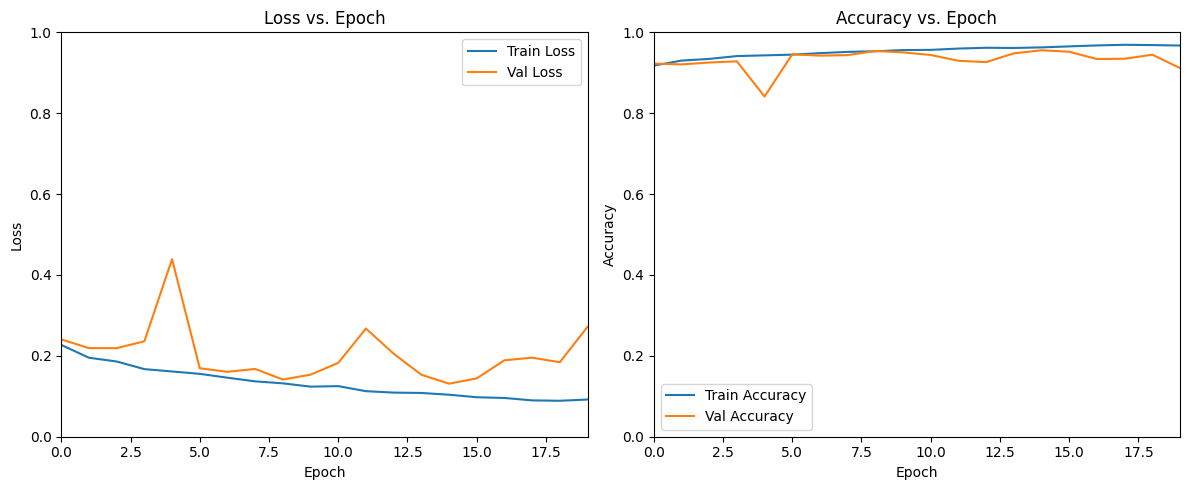

In [21]:
plot_history(history_efnet, 20)

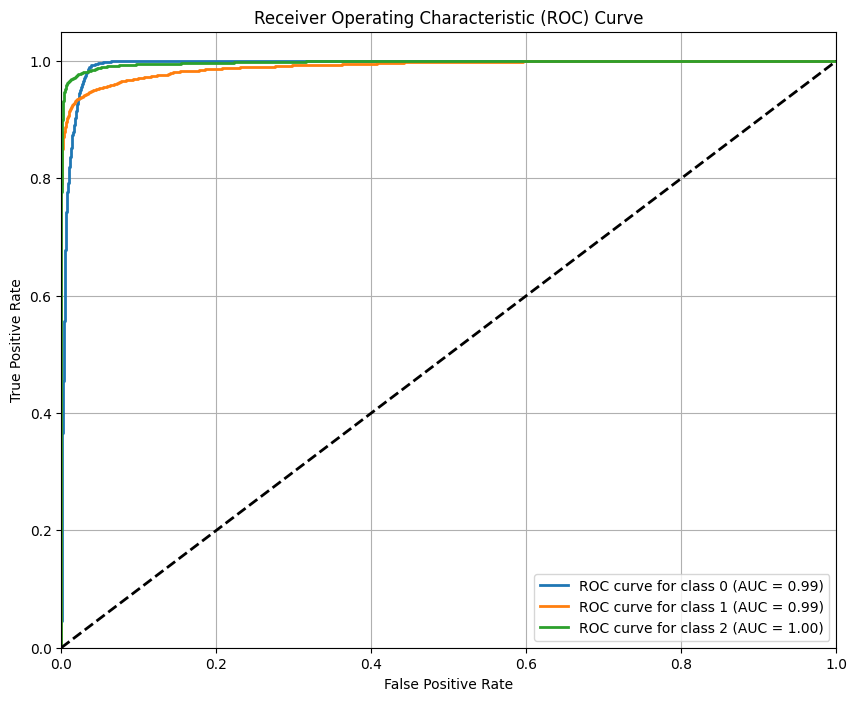

In [35]:
plot_roc_curves(fpr, tpr, roc_auc)

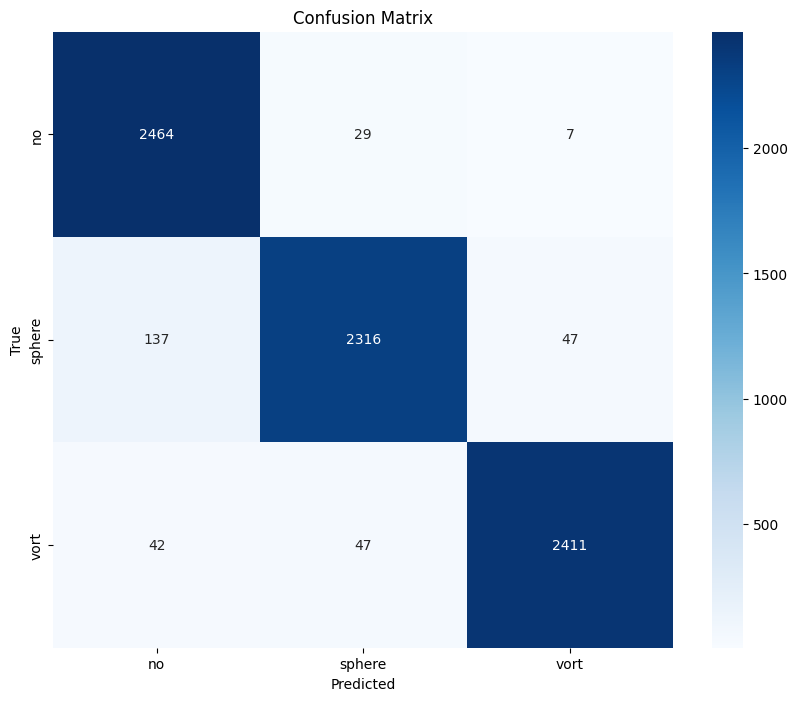

In [36]:
class_names = [k for k, v in sorted(class_to_idx.items(), key=lambda x: x[1])]
plot_confusion_matrix(cm, class_names)

## Inference code

In [ ]:
def load_classification_model(ckpt_path, model, num_classes=3, compile=False, use_half_precision=False):
    from collections import OrderedDict
    if model == 'resnet34':
        model = models.resnet34(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, num_classes)
    elif model == 'efficientnet_b3':
        model = models.efficientnet_b3(weights=None)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError("Unsupported model type. Use 'resnet34' or 'efficientnet_b3'.")

    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))

    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    elif isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace("_orig_mod.", "")
        new_state_dict[name] = v
    state_dict = new_state_dict
    
    model.load_state_dict(state_dict)

    if compile:
        model = torch.compile(model, mode="reduce-overhead")
    
    if use_half_precision:
        model = model.half()

    model = model.to(DEVICE)
    return model.eval()

ckpt_path = 'best_resnet34_classification_model.pt'
resnet_model = load_classification_model(ckpt_path, model="resnet34", compile=True, use_half_precision=True)
ckpt_path = 'best_efnet_b3_classification_model.pt'
efnet_model = load_classification_model(ckpt_path, model="efficientnet_b3", compile=True, use_half_precision=True)

/var/tmp/ipykernel_85481/2935307941.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))


In [48]:
def classify_image(model, image_path):
    model.to(DEVICE)
    image = np.load(image_path)
    image = torch.from_numpy(image).to(DEVICE, dtype=next(model.parameters()).dtype)
    image = image.unsqueeze(0)
    image = image.repeat(1, 3, 1, 1)
    image = transforms.Resize(256)(image)
    image = transforms.CenterCrop(224)(image)
    image = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(image)
    class_names = ['no', 'sphere', 'vort']
    probs = []
    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]

        for j, prob in enumerate(probabilities):
            probs.append(f"{class_names[j]}: {prob.item():.4f} ({prob.item()*100:.2f}%)")
    return probs

In [49]:
def measure_latency(model, iters=100):
    image_path = '/home/hamee/flow/classification_data/train/no/1.npy'
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    # warm up gpu
    for _ in range(5):
        classify_image(model, image_path=image_path)

    start_event.record()
    for _ in tqdm(range(iters)):
        classify_image(model, image_path=image_path)
    end_event.record()

    torch.cuda.synchronize()
    elapsed_time = start_event.elapsed_time(end_event) / iters
    return elapsed_time

In [50]:
resnet_latency = measure_latency(resnet_model, iters=100)
efnet_latency = measure_latency(efnet_model, iters=100)

100%|██████████| 100/100 [00:00<00:00, 152.55it/s]


In [51]:
print(f"ResNet34 Latency: {resnet_latency:.4f} ms")
print(f"EfficientNet-B3 Latency: {efnet_latency:.4f} ms")

ResNet34 Latency: 4.2193 ms
EfficientNet-B3 Latency: 6.5802 ms
